In [1]:
import os
import torch
import numpy as np
import sys
import time
sys.path.append('/share/data_supergrover1/heinrich/voxelmorph/pytorch/')
import torch.nn as nn
import torch.nn.functional as F
import losses
import re
import nibabel as nib
def gpu_usage():
    print('gpu usage (current/max): {:.2f} / {:.2f} GB'.format(torch.cuda.memory_allocated()*1e-9, torch.cuda.max_memory_allocated()*1e-9))

In [2]:
H=W=D=64
#correlation layer: dense discretised displacements to compute SSD cost volume with box-filter
def correlate(mind_fix,mind_mov,disp_hw,grid_sp,shape):
    H = int(shape[0]); W = int(shape[1]); D = int(shape[2]);

    torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad():
        mind_unfold = F.unfold(F.pad(mind_mov,(disp_hw,disp_hw,disp_hw,disp_hw,disp_hw,disp_hw)).squeeze(0),disp_hw*2+1)
        mind_unfold = mind_unfold.view(12,-1,(disp_hw*2+1)**2,W//grid_sp,D//grid_sp)
        

    ssd = torch.zeros((disp_hw*2+1)**3,H//grid_sp,W//grid_sp,D//grid_sp,dtype=mind_fix.dtype, device=mind_fix.device)#.cuda().half()
    ssd_argmin = torch.zeros(H//grid_sp,W//grid_sp,D//grid_sp).long()
    with torch.no_grad():
        for i in range(disp_hw*2+1):
            mind_sum = (mind_fix.permute(1,2,0,3,4)-mind_unfold[:,i:i+H//grid_sp]).pow(2).sum(0,keepdim=True)
            #5,stride=1,padding=2
            #3,stride=1,padding=1
            ssd[i::(disp_hw*2+1)] = F.avg_pool3d(F.avg_pool3d(mind_sum.transpose(2,1),3,stride=1,padding=1),3,stride=1,padding=1).squeeze(1)
        ssd = ssd.view(disp_hw*2+1,disp_hw*2+1,disp_hw*2+1,H//grid_sp,W//grid_sp,D//grid_sp).transpose(1,0).reshape((disp_hw*2+1)**3,H//grid_sp,W//grid_sp,D//grid_sp)
        ssd_argmin = torch.argmin(ssd,0)#
        #ssd = F.softmax(-ssd*1000,0)
    torch.cuda.synchronize()

    t1 = time.time()
    #print(t1-t0,'sec (ssd)')
    #gpu_usage()
    return ssd,ssd_argmin

#solve two coupled convex optimisation problems for efficient global regularisation
def coupled_convex(ssd,ssd_argmin,disp_mesh_t,grid_sp,shape):
    H = int(shape[0]); W = int(shape[1]); D = int(shape[2]);

    disp_soft = F.avg_pool3d(disp_mesh_t.view(3,-1)[:,ssd_argmin.view(-1)].reshape(1,3,H//grid_sp,W//grid_sp,D//grid_sp),3,padding=1,stride=1)

    coeffs = torch.tensor([0.003,0.01,0.03,0.1,0.3,1])
    for j in range(6):
        ssd_coupled_argmin = torch.zeros_like(ssd_argmin)
        with torch.no_grad():
            for i in range(H//grid_sp):

                coupled = ssd[:,i,:,:]+coeffs[j]*(disp_mesh_t-disp_soft[:,:,i].view(3,1,-1)).pow(2).sum(0).view(-1,W//grid_sp,D//grid_sp)
                ssd_coupled_argmin[i] = torch.argmin(coupled,0)
            #print(coupled.shape)

        disp_soft = F.avg_pool3d(disp_mesh_t.view(3,-1)[:,ssd_coupled_argmin.view(-1)].reshape(1,3,H//grid_sp,W//grid_sp,D//grid_sp),3,padding=1,stride=1)

    return disp_soft

#enforce inverse consistency of forward and backward transform
def inverse_consistency(disp_field1s,disp_field2s,iter=20):
    #factor = 1
    B,C,H,W,D = disp_field1s.size()
    #make inverse consistent
    with torch.no_grad():
        disp_field1i = disp_field1s.clone()
        disp_field2i = disp_field2s.clone()

        identity = F.affine_grid(torch.eye(3,4).unsqueeze(0),(1,1,H,W,D)).permute(0,4,1,2,3).to(disp_field1s.device).to(disp_field1s.dtype)
        for i in range(iter):
            disp_field1s = disp_field1i.clone()
            disp_field2s = disp_field2i.clone()

            disp_field1i = 0.5*(disp_field1s-F.grid_sample(disp_field2s,(identity+disp_field1s).permute(0,2,3,4,1)))
            disp_field2i = 0.5*(disp_field2s-F.grid_sample(disp_field1s,(identity+disp_field2s).permute(0,2,3,4,1)))

    return disp_field1i,disp_field2i

def combineDeformation3d(disp_1st,disp_2nd,identity):
    disp_composition = disp_2nd + F.grid_sample(disp_1st,disp_2nd.permute(0,2,3,4,1)+identity)
    return disp_composition

device = 'cuda'

def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

def convexAdam(img_fixed,img_moving):
    grid_sp = 4
    disp_hw = 8
    #compute MIND descriptors and downsample (using average pooling)
    with torch.no_grad():
        mindssc_fix = losses.MINDSSC(img_fixed.unsqueeze(0).unsqueeze(0).cuda(),1,2).half()#*fixed_mask.cuda().half()#.cpu()
        mindssc_mov = losses.MINDSSC(img_moving.unsqueeze(0).unsqueeze(0).cuda(),1,2).half()#*moving_mask.cuda().half()#.cpu()
        mind_fix = F.avg_pool3d(mindssc_fix,grid_sp,stride=grid_sp)
        mind_mov = F.avg_pool3d(mindssc_mov,grid_sp,stride=grid_sp)

    ssd,ssd_argmin = correlate(mind_fix,mind_mov,disp_hw,grid_sp,(H,W,D))
    disp_mesh_t = F.affine_grid(disp_hw*torch.eye(3,4).cuda().half().unsqueeze(0),(1,1,disp_hw*2+1,disp_hw*2+1,disp_hw*2+1),align_corners=True).permute(0,4,1,2,3).reshape(3,-1,1)
    disp_soft = coupled_convex(ssd,ssd_argmin,disp_mesh_t,grid_sp,(H,W,D))
    scale = torch.tensor([H//grid_sp-1,W//grid_sp-1,D//grid_sp-1]).view(1,3,1,1,1).cuda().half()/2
    ssd_,ssd_argmin_ = correlate(mind_mov,mind_fix,disp_hw,grid_sp,(H,W,D))
    disp_soft_ = coupled_convex(ssd_,ssd_argmin_,disp_mesh_t,grid_sp,(H,W,D))
    disp_ice,_ = inverse_consistency((disp_soft/scale).flip(1),(disp_soft_/scale).flip(1),iter=15)
    disp_hr = F.interpolate(disp_ice.flip(1)*scale*grid_sp,size=(H,W,D),mode='trilinear',align_corners=False)
    grid_sp = 3
    with torch.no_grad():
        patch_mind_fix = F.avg_pool3d(mindssc_fix,grid_sp,stride=grid_sp)
        patch_mind_mov = F.avg_pool3d(mindssc_mov,grid_sp,stride=grid_sp)
    #create optimisable displacement grid
    disp_lr = F.interpolate(disp_hr,size=(H//grid_sp,W//grid_sp,D//grid_sp),mode='trilinear',align_corners=False)
    net = nn.Sequential(nn.Conv3d(3,1,(H//grid_sp,W//grid_sp,D//grid_sp),bias=False))
    net[0].weight.data[:] = disp_lr.float().cpu().data/grid_sp
    net.cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=1)
    grid0 = F.affine_grid(torch.eye(3,4).unsqueeze(0).cuda(),(1,1,H//grid_sp,W//grid_sp,D//grid_sp),align_corners=False)
    #run Adam optimisation with diffusion regularisation and B-spline smoothing
    lambda_weight = .6# with tps: .5, without:0.7
    for iter in range(40):#80
        optimizer.zero_grad()
        disp_sample = F.avg_pool3d(F.avg_pool3d(F.avg_pool3d(net[0].weight,3,stride=1,padding=1),3,stride=1,padding=1),3,stride=1,padding=1).permute(0,2,3,4,1)
        reg_loss = lambda_weight*((disp_sample[0,:,1:,:]-disp_sample[0,:,:-1,:])**2).mean()+\
        lambda_weight*((disp_sample[0,1:,:,:]-disp_sample[0,:-1,:,:])**2).mean()+\
        lambda_weight*((disp_sample[0,:,:,1:]-disp_sample[0,:,:,:-1])**2).mean()
        scale = torch.tensor([(H//grid_sp-1)/2,(W//grid_sp-1)/2,(D//grid_sp-1)/2]).cuda().unsqueeze(0)
        grid_disp = grid0.view(-1,3).cuda().float()+((disp_sample.view(-1,3))/scale).flip(1).float()
        patch_mov_sampled = F.grid_sample(patch_mind_mov.float(),grid_disp.view(1,H//grid_sp,W//grid_sp,D//grid_sp,3).cuda(),align_corners=False,mode='bilinear')#,padding_mode='border')
        sampled_cost = (patch_mov_sampled-patch_mind_fix).pow(2).mean(1)*12
        loss = sampled_cost.mean()
        (loss+reg_loss).backward()
        optimizer.step()

    fitted_grid = disp_sample.permute(0,4,1,2,3).detach()
    disp_hr = F.interpolate(fitted_grid*grid_sp,size=(H,W,D),mode='trilinear',align_corners=False)
    disp_smooth = F.avg_pool3d(F.avg_pool3d(F.avg_pool3d(disp_hr,3,padding=1,stride=1),3,padding=1,stride=1),3,padding=1,stride=1)
    disp = disp_smooth.cuda().float().permute(0,2,3,4,1)/torch.tensor([H-1,W-1,D-1]).cuda().view(1,1,1,1,3)*2
    disp = disp.flip(4)
    return disp

In [3]:
#folder = '/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/L4_fine_localized_crop/source_training_labeled/'
folder = '/share/data_supergrover1/hansen/temp/crossMoDa/preprocessed_new/resampled/localised_crop/source_training/'
files = sorted(os.listdir(folder))
print(len(files),files[0:4])

421 ['.ipynb_checkpoints', 'crossmoda_100_Label_l.nii.gz', 'crossmoda_100_Label_r.nii.gz', 'crossmoda_100_ceT1_l.nii.gz']


In [4]:
import subprocess
source_tumour_left = []
source_tumour_right = []
for f in files:
    #print(f)
    if('Label_l' in f):
        output = subprocess.run(["/share/data_supergrover1/heinrich/c3d",folder+f, "-replace", "2", "0","-voxel-sum" ], capture_output=True)
        if('Voxel Sum' in str(output.stdout)):
            count = (int(str(output.stdout).split('\\n')[0].split(':')[1]))
            if(count>50):
                source_tumour_left.append([f,count])
    if('Label_r' in f):
        output = subprocess.run(["/share/data_supergrover1/heinrich/c3d",folder+f, "-replace", "2", "0","-voxel-sum" ], capture_output=True)
        if('Voxel Sum' in str(output.stdout)):
            count = (int(str(output.stdout).split('\\n')[0].split(':')[1]))
            if(count>50):
                source_tumour_right.append([f,count])
    

In [5]:
print(output.stdout)

b'Voxel Sum: 9807\n'


In [6]:
print(len(source_tumour_right),len(source_tumour_left))

63 44


In [7]:
#folder1 = '/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/L4_fine_localized_crop/__omitted_labels_target_training__/'
#folder1b = '/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/L4_fine_localized_crop/target_training_unlabeled/'
folder1 = '/share/data_supergrover1/hansen/temp/crossMoDa/preprocessed_new/resampled/localised_crop/target_training/'


files1 = sorted(os.listdir(folder1))
print(len(files1),files1[0:3])

121 ['.ipynb_checkpoints', 'crossmoda_108_Label_r.nii.gz', 'crossmoda_108_hrT2_r.nii.gz']


In [8]:
import subprocess
target_tumour_left = []
target_tumour_right = []
for f in files1:
    if('Label_l' in f):
        output = subprocess.run(["/share/data_supergrover1/heinrich/c3d",folder1+f, "-replace", "2", "0","-voxel-sum" ], capture_output=True)
        count = (int(str(output.stdout).split('\\n')[0].split(':')[1]))
        if(count>50):
            target_tumour_left.append([f,count])
    if('Label_r' in f):
        output = subprocess.run(["/share/data_supergrover1/heinrich/c3d",folder1+f, "-replace", "2", "0","-voxel-sum" ], capture_output=True)
        count = (int(str(output.stdout).split('\\n')[0].split(':')[1]))
        if(count>50):
            target_tumour_right.append([f,count])
    

In [ ]:
print(len(target_tumour_right),len(target_tumour_left))
#!mkdir crossmoda_deeds

In [9]:
FIXED_NUM = 60
MOVING_NUM = 30

In [10]:
dicesi = torch.zeros(FIXED_NUM,MOVING_NUM,2)
for fixed_id in range(FIXED_NUM):
    
    #output = torch.zeros(30,128,128,128).short().pin_memory()
    dices = torch.zeros(MOVING_NUM,2)
    t0 = time.time()
    for moving_id in range(MOVING_NUM):
        base = source_tumour_right[fixed_id][0][:-13]


        warped_seg = torch.from_numpy(nib.load('/share/data_supergrover1/heinrich/crossmoda_convex/'+base+str(target_tumour_right[moving_id][0][:17].split('_')[1])+'.nii.gz').get_fdata())


        #disp = convexAdam(imgs_t2[fixed_id,crop[0]:-crop[1],48:-16,40:-24].cuda(),imgs_t1[moving_id,crop[0]:-crop[1],48:-16,40:-24].cuda())
        #warped_seg = F.grid_sample(segs_t1[moving_id:moving_id+1,crop[0]:-crop[1],48:-16,40:-24].float().unsqueeze(1).cuda(),\
        #                           F.affine_grid(torch.eye(3,4).cuda().unsqueeze(0),(1,1,H,W,D))+disp.cuda(),mode='nearest')
        #output[moving_id,crop[0]:-crop[1],48:-16,40:-24] = warped_seg.cpu().squeeze().cpu()
        d0 = dice_coeff(segs_t2[fixed_id].contiguous(),segs_t1[moving_id].contiguous().cpu(),3)
        d1 = dice_coeff(segs_t2[fixed_id].contiguous(),warped_seg.squeeze().long().contiguous().cpu(),3)
        dices[moving_id,0] = d0[0]
        dices[moving_id,1] = d1[0]
        
    #print(fixed_id,moving_id,d0[1],d1[1])
    dicesi[fixed_id] = dices
    t1 = time.time()
    print(torch.quantile(dices[:,1],q=torch.linspace(0,1,5)))
    print(fixed_id,t1-t0,'sec (dice)',dices.mean(0))
    


NameError: name 'segs_t2' is not defined

In [ ]:
import matplotlib.pyplot as plt
print(dicesi.shape)
plt.plot(torch.linspace(0,1,FIXED_NUM**2),torch.sort(dicesi[:,:,1].reshape(-1))[0],label='convex')
plt.plot(torch.linspace(0,1,FIXED_NUM**2),torch.sort(deeds_dice.reshape(-1))[0],label='deeds')
plt.plot(torch.linspace(0,1,FIXED_NUM**2),torch.sort(dicesi[:,:,0].reshape(-1))[0],label='before')
plt.legend()
plt.show()

In [ ]:
deeds_dice_left = torch.zeros(FIXED_NUM,MOVING_NUM)
for fixed_id in range(FIXED_NUM):
    for moving_id in range(MOVING_NUM):
        out = 'crossmoda_deeds/F'+target_tumour_left[fixed_id][0][:-13]+'_M'+str(source_tumour_left[moving_id][0][:17].split('_')[1])
        
        output = subprocess.run(["./deedsBCV/diceMulti",folder1+target_tumour_left[fixed_id][0],out+'_deformed_seg.nii.gz'], capture_output=True)
        value = float(str(output.stdout).split(':')[1].split(',')[0])
        print('dice',value)
        deeds_dice_left[fixed_id,moving_id] = value
        

In [ ]:
deeds_dice_left = torch.zeros(FIXED_NUM,MOVING_NUM)
for fixed_id in range(FIXED_NUM):
    for moving_id in range(MOVING_NUM):
        out = 'crossmoda_deeds/F'+target_tumour_left[fixed_id][0][:-13]+'_M'+str(source_tumour_left[moving_id][0][:17].split('_')[1])
        cmd = './deedsBCV/deedsBCV -F '+folder1+target_tumour_left[fixed_id][0][:-14]+'hrT2_l.nii.gz -M '+folder+source_tumour_left[moving_id][0][:-14]+'ceT1_l.nii.gz -S '+folder+source_tumour_left[moving_id][0]+' -O '+out
        !{cmd}
        cmd2 = 'rm '+out+'_deformed.nii.gz'
        cmd2 = 'rm '+out+'_displacements.dat'

        output = subprocess.run(["./deedsBCV/diceMulti",folder1+target_tumour_left[fixed_id][0],out+'_deformed_seg.nii.gz'], capture_output=True)
        value = float(str(output.stdout).split(':')[1].split(',')[0])
        print('dice',value)
        deeds_dice_left[fixed_id,moving_id] = value
    torch.save(deeds_dice_left,'crossmoda_deeds/dice_left.pth')



In [ ]:
deeds_dice = torch.zeros(FIXED_NUM,MOVING_NUM)
for fixed_id in range(FIXED_NUM):
    for moving_id in range(MOVING_NUM):
        out = 'crossmoda_deeds/F'+target_tumour_right[fixed_id][0][:-13]+'_M'+str(source_tumour_right[moving_id][0][:17].split('_')[1])
        cmd = './deedsBCV/deedsBCV -F '+folder1+target_tumour_right[fixed_id][0][:-14]+'hrT2_r.nii.gz -M '+folder+source_tumour_right[moving_id][0][:-14]+'ceT1_r.nii.gz -S '+folder+source_tumour_right[moving_id][0]+' -O '+out
        !{cmd}
        cmd2 = 'rm '+out+'_deformed.nii.gz'
        cmd2 = 'rm '+out+'_displacements.dat'

        output = subprocess.run(["./deedsBCV/diceMulti",folder1+target_tumour_right[fixed_id][0],out+'_deformed_seg.nii.gz'], capture_output=True)
        value = float(str(output.stdout).split(':')[1].split(',')[0])
        print('dice',value)
        deeds_dice[fixed_id,moving_id] = value
    torch.save(deeds_dice,'crossmoda_deeds/dice_right.pth')



In [ ]:
print(deeds_dice)

In [ ]:
!ls crossmoda_deeds/*

In [ ]:
len(source_tumour_right)

In [11]:
segs_t1 = torch.zeros(FIXED_NUM,128,128,128)
imgs_t1 = torch.zeros(FIXED_NUM,128,128,128).pin_memory()
segs_t2 = torch.zeros(FIXED_NUM,128,128,128)
imgs_t2 = torch.zeros(FIXED_NUM,128,128,128).pin_memory()

for fixed_id in range(FIXED_NUM):
    if fixed_id < 30:
        # Load right targets (only 30) (register right to right)
        segs_t1[fixed_id] = torch.from_numpy(nib.load(folder+source_tumour_right[fixed_id][0]).get_fdata()).float()
        segs_t2[fixed_id] = torch.from_numpy(nib.load(folder1+target_tumour_right[fixed_id][0]).get_fdata()).float()
        imgs_t1[fixed_id] = torch.from_numpy(nib.load(folder+source_tumour_right[fixed_id][0][:-14]+'ceT1_r.nii.gz').get_fdata()).float()
        imgs_t2[fixed_id] = torch.from_numpy(nib.load(folder1+target_tumour_right[fixed_id][0][:-14]+'hrT2_r.nii.gz').get_fdata()).float()
    else:
        # Load left targets (only 30) (register left to left)
        offset_id = fixed_id - 30
        segs_t1[fixed_id] = torch.from_numpy(nib.load(folder+source_tumour_left[offset_id][0]).get_fdata()).float()
        segs_t2[fixed_id] = torch.from_numpy(nib.load(folder1+target_tumour_left[offset_id][0]).get_fdata()).float()
        imgs_t1[fixed_id] = torch.from_numpy(nib.load(folder+source_tumour_left[offset_id][0][:-14]+'ceT1_l.nii.gz').get_fdata()).float()
        imgs_t2[fixed_id] = torch.from_numpy(nib.load(folder1+target_tumour_left[offset_id][0][:-14]+'hrT2_l.nii.gz').get_fdata()).float()

In [ ]:
len(source_tumour_left)

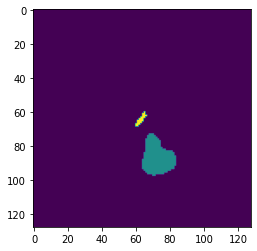

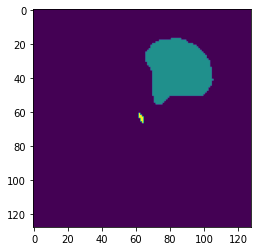

In [46]:
import matplotlib.pyplot as plt
idx = 29
# plt.imshow(segs_t1[:29].sum((0,1)))
plt.imshow(segs_t2[29,:,:,70]); plt.show()
plt.imshow(segs_t2[31,:,:,70]); plt.show()

In [ ]:
segs_t2.shape

In [ ]:
print(torch.sum(segs_t1),torch.sum(segs_t1[:,8:-56,48:-16,40:-24]))



In [95]:
# print(torch.sum(segs_t1),torch.sum(segs_t1[:,56:-8,48:-16,40:-24]))
# print(imgs_t1[0,56:-8,48:-16,40:-24].shape)

im_print = False
import  matplotlib.pyplot as plt
# print(torch.sum(segs_t1),torch.sum(segs_t1[:,crop[0]:crop[1],48:-16,40:-24]))

dicesi = torch.zeros(FIXED_NUM,MOVING_NUM,2)
for fixed_id in range(FIXED_NUM):
    if fixed_id < 30:
        # crop = [56,-8]#right
        f_crop = [slice(56,-8), slice(48,-16), slice(40,-24)]
        crop = [slice(56,-8), slice(48,-16), slice(40,-24)]
    else:
        # crop = [8,-56]#left
        f_crop = [slice(8,-56), slice(48,-16), slice(40,-24)]
        crop = [slice(56,-8), slice(48,-16), slice(40,-24)]

    output = torch.zeros(MOVING_NUM,128,128,128).short().pin_memory()
    dices = torch.zeros(MOVING_NUM,2)
    t0 = time.time()

    fixed_img = imgs_t2[fixed_id][f_crop]
    fixed_seg = segs_t2[fixed_id][f_crop]

    if im_print:
        print("fixedimg")
        plt.imshow(fixed_img[..., 32].cpu()); plt.show()
        print()
        print("fixedseg")
        plt.imshow(fixed_seg.squeeze()[..., 32].cpu()); plt.show()
        print()

    for moving_id in range(MOVING_NUM):
        moving_img = imgs_t1[moving_id]
        moving_img = moving_img[crop]

        moving_seg = segs_t1[moving_id][crop].unsqueeze(0)
        moving_seg = moving_seg.float().unsqueeze(1).cuda()

        disp = convexAdam(fixed_img.cuda(), moving_img.cuda())
        warped_seg = F.grid_sample(moving_seg,\
                                   F.affine_grid(torch.eye(3,4).cuda().unsqueeze(0),(1,1,H,W,D))+disp.cuda(),mode='nearest')
        output[moving_id][crop] = warped_seg.cpu().squeeze().cpu()
        d0 = dice_coeff(fixed_seg.contiguous(),moving_seg.contiguous().cpu(),3)
        d1 = dice_coeff(fixed_seg.contiguous(),warped_seg.squeeze().long().contiguous().cpu(),3)
        dices[moving_id,0] = d0[0]
        dices[moving_id,1] = d1[0]
        if im_print:
            print("movingimg")
            plt.imshow(moving_img[..., 32].cpu()); plt.show()
            print()

            print("movingseg")
            plt.imshow(moving_seg.squeeze()[..., 32].cpu()); plt.show()
            print()

            print("warpedseg")
            plt.imshow(warped_seg.squeeze()[..., 32].cpu()); plt.show()
            print()

    print(f"dice f{fixed_id} mean, before {dices[:,0].mean()}, after {dices[:,1].mean()}")
    dicesi[fixed_id] = dices
    t1 = time.time()
    print(torch.quantile(dices[:,1],q=torch.linspace(0,1,5)))
    print(fixed_id,t1-t0,'sec (reg)')
    t0 = time.time()

    for moving_id in range(MOVING_NUM):
        if fixed_id < 30:
            lr_id = 'r'
            moving = source_tumour_right[moving_id][0][:-14]
            moving = re.findall(r'\d{1,3}', moving)[0]
            fixed = str(target_tumour_right[fixed_id][0][:17].split('_')[1])
        else:
            offset_id = fixed_id - 30
            moving = source_tumour_left[moving_id][0][:-14]
            moving = re.findall(r'\d{1,3}', moving)[0]
            fixed = str(target_tumour_left[offset_id][0][:17].split('_')[1])
            lr_id = 'l'


        base = f"crossmoda_F{fixed}{lr_id}_M{moving}{lr_id}"
        fp = '/share/data_supergrover1/weihsbach/shared_data/tmp/tmp_convex/'+base+'.nii.gz'
        nib.save(nib.Nifti1Image(output[moving_id].numpy(),np.eye(4)),fp)
        # print(f"Saving '{fp}'")
    t1 = time.time()
    print(t1-t0,'sec (save)')


dice f0 mean, before 0.2108212560415268, after 0.35353514552116394
tensor([0.0000, 0.2373, 0.3483, 0.4667, 0.6686])
0 3.8777554035186768 sec (reg)
0.6344618797302246 sec (save)
dice f1 mean, before 0.31389275193214417, after 0.46082624793052673
tensor([0.0011, 0.2951, 0.4497, 0.6459, 0.8330])
1 3.7384390830993652 sec (reg)
0.6112821102142334 sec (save)
dice f2 mean, before 0.23661552369594574, after 0.2502635419368744
tensor([0.0000, 0.0303, 0.1424, 0.3733, 0.8649])
2 3.7465200424194336 sec (reg)
0.6293308734893799 sec (save)
dice f3 mean, before 0.0, after 0.0
tensor([0., 0., 0., 0., 0.])
3 3.759416341781616 sec (reg)
0.611203670501709 sec (save)
dice f4 mean, before 0.194319486618042, after 0.24602331221103668
tensor([0.0000, 0.0274, 0.1245, 0.4866, 0.6820])
4 3.7471437454223633 sec (reg)
0.6315832138061523 sec (save)
dice f5 mean, before 0.29690104722976685, after 0.3543040454387665
tensor([1.4540e-04, 1.0299e-01, 2.4321e-01, 6.2641e-01, 8.6839e-01])
5 3.734908103942871 sec (reg)
0.

In [ ]:
torch.save({'dice':dicesi,'source_tumour_right':source_tumour_right,'target_tumour_right':target_tumour_right},'crossmoda_convex/dice_files_right.pth')

In [ ]:
print('before',dicesi[:,:,0].max(0)[0].mean())
print('before',dicesi[:,:,0].max(1)[0].mean())
print('after',dicesi[:,:,1].max(0)[0].mean())
print('after',dicesi[:,:,1].max(1)[0].mean())

In [ ]:
print('before',torch.quantile(dicesi[:,:,0],dim=1,q=torch.linspace(0,1,5)).mean(1))
print('after',torch.quantile(dicesi[:,:,1],dim=1,q=torch.linspace(0,1,5)).mean(1))

#print(dicesi[:,:,1].max(1)[0])



In [ ]:
disp = convexAdam(img3d[fix,56:-8,48:-16,40:-24],img3d_t2[fixed_id,56:-8,48:-16,40:-24])
warped_one_hot = F.grid_sample(F.one_hot(seg3d_t2[fixed_id,56:-8,48:-16,40:-24].long(),3).permute(3,0,1,2).float().cuda().view(1,3,H,W,D),F.affine_grid(torch.eye(3,4).cuda().unsqueeze(0),(1,1,H,W,D))+disp.cuda(),mode='bilinear')
combined += warped_one_hot.squeeze().cpu()
warped_seg = warped_one_hot.argmax(1).squeeze()
mov_all[fixed_id,56:-8,48:-16,40:-24] = warped_seg
before[fixed_id] = (dice_coeff(seg3d[fix,56:-8,48:-16,40:-24],seg3d_t2[fixed_id,56:-8,48:-16,40:-24],3))
after[fixed_id] = (dice_coeff(seg3d[fix,56:-8,48:-16,40:-24],warped_seg.squeeze().cpu(),3))

In [ ]:
#print(len(target_tumour_right),len(target_tumour_left))
print(source_tumour_right[fixed_id][0][:-13]+'.nii.gz')

In [96]:
# Pack registrations into a dict

import torch
import glob
import re
import os
import nibabel as nib
from mdl_seg_class.metrics import dice3d
import torch.nn.functional as F

in_notebook = True

if in_notebook:
    THIS_SCRIPT_DIR = os.path.abspath('')
else:
    THIS_SCRIPT_DIR = os.path.dirname(os.path.realpath(__file__))

load_set = "convex"

if load_set == "convex":
    data_path = "/share/data_supergrover1/weihsbach/shared_data/tmp/tmp_convex/"
    convex_path =  "/share/data_supergrover1/heinrich/crossmoda_convex/"
    registered_files = glob.glob(data_path+"*.nii.gz")
    # registered_files = ["/share/data_supergrover1/weihsbach/shared_data/tmp/tmp_convex/Fcrossmoda108_M100.nii.gz"]
elif load_set == "deeds":
    data_path = "/share/data_supergrover1/heinrich/crossmoda_deeds/"
    convex_path =  "/share/data_supergrover1/heinrich/crossmoda_convex/"
    registered_files = glob.glob(data_path+"*seg.nii.gz")

dice_files_right = torch.load(convex_path+"dice_files_right.pth")
dice_files_left = torch.load(convex_path+"dice_files_left.pth")

orig_path = "/share/data_supergrover1/weihsbach/shared_data/tmp/CrossMoDa/L4_fine_localized_crop/"

# print(registered_files)
dice_files_right = torch.load(convex_path+"dice_files_right.pth")
dice_files_left = torch.load(convex_path+"dice_files_left.pth")

fixed_files_right = dice_files_right['target_tumour_right']
fixed_files_right = set([elem[0] for elem in fixed_files_right])
fixed_files_left = dice_files_left['target_tumour_left']
fixed_files_left = set([elem[0] for elem in fixed_files_left])

moving_files_right = dice_files_right['source_tumour_right']
moving_files_right = set([elem[0] for elem in moving_files_right])
moving_files_left = dice_files_left['source_tumour_left']
moving_files_left = set([elem[0] for elem in moving_files_left])

all_fixed_files = sorted(list(fixed_files_left.union(fixed_files_right)))
all_moving_files = sorted(list(moving_files_left.union(moving_files_right)))


def filter_ids(_file):
    num_id, lr_id = re.findall(r"(\d{1,3})_Label_([lr])", _file)[0]
    _id = f'{int(num_id):03d}{lr_id}'
    numeric_short = int(_id[:3])
    return (_id, numeric_short, _file)

fixed_ids = [filter_ids(f_name) for f_name in all_fixed_files]
moving_ids = [filter_ids(f_name) for f_name in all_moving_files]

data_dict = {}

used_fids_short = []
used_mids_short = []

def get_convex_fixed_moving_num(_file):
    fixed_num, moving_num = re.findall(r"(\d{1,3})[rl]_M(\d{1,3})", _file)[0]
    fixed_num, moving_num = int(fixed_num), int(moving_num)
    return fixed_num, moving_num

def get_deeds_fixed_moving_num(_file):
    fixed_num, moving_num = re.findall(r"(\d{1,3})_L_M(\d{1,3})", _file)[0]
    fixed_num, moving_num = int(fixed_num), int(moving_num)
    return fixed_num, moving_num

for gz_file in registered_files:
    if load_set == "convex":
        fixed_num, moving_num = get_convex_fixed_moving_num(gz_file)
    elif load_set == "deeds":
        fixed_num, moving_num = get_deeds_fixed_moving_num(gz_file)
    used_fids_short.append(fixed_num)
    used_mids_short.append(moving_num)

used_fids_short = list(set(used_fids_short))
used_mids_short = list(set(used_mids_short))

fixed_ids = list(filter(lambda elem: elem[1] in used_fids_short, fixed_ids))
moving_ids = list(filter(lambda elem: elem[1] in used_mids_short, moving_ids))

print("fixed_ids", fixed_ids)
print("moving_ids", moving_ids)

orig_label_dict = {}

for _id, _, _file in fixed_ids:
    file_path = orig_path + "__omitted_labels_target_training__/" + _file
    file_path = file_path.replace("Label_l", "hrT2_l_Label")
    file_path = file_path.replace("Label_r", "hrT2_r_Label")
    if os.path.isfile(file_path):
        orig_label_dict[_id] = torch.tensor(nib.load(file_path).get_fdata())

warped_label_dict = {}
for gz_file in registered_files:
    if load_set == "convex":
        fixed_num, moving_num = get_convex_fixed_moving_num(gz_file)
        # gz_file = data_path + f"crossmoda_{fixed_num}_L{moving_num}.nii.gz"
    elif load_set == "deeds":
        fixed_num, moving_num = get_deeds_fixed_moving_num(gz_file)

    warped_label = torch.tensor(nib.load(gz_file).get_fdata()).cuda()

    fixed_id = list(filter(lambda elem: elem[1] == fixed_num, fixed_ids))
    if not fixed_id:
        continue
    else:
        fixed_id = fixed_id[0][0]
    moving_id = list(filter(lambda elem: elem[1] == moving_num, moving_ids))
    if not moving_id:
        continue
    else:
        moving_id = moving_id[0][0]

    dct = warped_label_dict.get(fixed_id, {})
    dct[moving_id] = warped_label.to_sparse()
    warped_label_dict[fixed_id] = dct

print(len(orig_label_dict))

for idx, gz_file in enumerate(registered_files):
    if load_set == "convex":
        fixed_num, moving_num = get_convex_fixed_moving_num(gz_file)
    elif load_set == "deeds":
        fixed_num, moving_num = get_deeds_fixed_moving_num(gz_file)

    fixed_res = list(filter(lambda elem: elem[1] == fixed_num, fixed_ids))
    if not fixed_res:
        continue
    else:
        fixed_id, _, fixed_file = fixed_res[0]

    moving_res = list(filter(lambda elem: elem[1] == moving_num, moving_ids))
    if not moving_res:
        continue
    else:
        moving_id, _, moving_file = moving_res[0]
    dct = data_dict.get(fixed_id, {})

    # orig_label = orig_label_dict[moving_id].cuda() # TODO
    orig_label = orig_label_dict[fixed_id].cuda()
    warped_label = warped_label_dict[fixed_id][moving_id].to_dense()

    dice = dice3d(F.one_hot(orig_label.long(), 3).unsqueeze(0),
          F.one_hot(warped_label.long(), 3).unsqueeze(0), one_hot_torch_style=True)

    dct[moving_id] = {
        'warped_label': warped_label.to_sparse(),
        'dice': dice
    }
    data_dict[fixed_id] = dct

    if idx % 60 == 0:
    # if len(orig_label.unique()) != len(warped_label.unique()) or len(orig_label.unique()) < 2:
        print(idx)
        print(orig_label.unique())
        print(warped_label.unique())
        print("Registred file: ", gz_file)
        print("Fixed file: ", fixed_file)
        print("Moving file: ", moving_file)
        print(f"fixed: {fixed_num}, moving: {moving_num}")
        print(f"fixed: {fixed_id}, moving: {moving_id}")
        print(dice)
        print()

torch.save(data_dict, THIS_SCRIPT_DIR+f"/crossmoda_{load_set}_registered_new_convex.pth")


fixed_ids [('108r', 108, 'crossmoda_108_Label_r.nii.gz'), ('111l', 111, 'crossmoda_111_Label_l.nii.gz'), ('112r', 112, 'crossmoda_112_Label_r.nii.gz'), ('115l', 115, 'crossmoda_115_Label_l.nii.gz'), ('117l', 117, 'crossmoda_117_Label_l.nii.gz'), ('118r', 118, 'crossmoda_118_Label_r.nii.gz'), ('120r', 120, 'crossmoda_120_Label_r.nii.gz'), ('123r', 123, 'crossmoda_123_Label_r.nii.gz'), ('125l', 125, 'crossmoda_125_Label_l.nii.gz'), ('126l', 126, 'crossmoda_126_Label_l.nii.gz'), ('127r', 127, 'crossmoda_127_Label_r.nii.gz'), ('133l', 133, 'crossmoda_133_Label_l.nii.gz'), ('134r', 134, 'crossmoda_134_Label_r.nii.gz'), ('135r', 135, 'crossmoda_135_Label_r.nii.gz'), ('136l', 136, 'crossmoda_136_Label_l.nii.gz'), ('140l', 140, 'crossmoda_140_Label_l.nii.gz'), ('141l', 141, 'crossmoda_141_Label_l.nii.gz'), ('142r', 142, 'crossmoda_142_Label_r.nii.gz'), ('143l', 143, 'crossmoda_143_Label_l.nii.gz'), ('144r', 144, 'crossmoda_144_Label_r.nii.gz'), ('145l', 145, 'crossmoda_145_Label_l.nii.gz'), ('